# BERT를 활용한 단일 문장 분류 실습

> 작성자      
```
* 김성현 (bananaband657@gmail.com)  
김바다 (qkek983@gmail.com)
박상희 (parksanghee0103@gmail.com)  
이정우 (jungwoo.l2.rs@gmail.com)
```
[CC BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/2.0/kr/)

이번 시간에는 BERT를 활용해, 단일 문장을 분류하는 task를 실습해보겠습니다.

In [1]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 50.2MB/s 
     |████████████████████████████████| 870kB 34.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=cb8e2a4818f7d4bf1156f72db17f523a31207d804e947416057107a3ec1c7b31
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 194kB 7.3MB/s 
     |████████████████████████████████| 112kB 11.2MB/s 
     |████████████████████████████████| 245kB 8.3MB/s 


In [2]:
import torch
import datasets
import sys

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# 사용가능한 dataset list 불러오기
dataset_list = datasets.list_datasets()

# dataset list 확인
for datas in dataset_list:
    if 'ko' in datas:
        print(datas)

kor_3i4k
kor_hate
kor_ner
kor_nli
kor_nlu
kor_qpair
kor_sae
kor_sarcasm
squad_kor_v1
squad_kor_v2
abwicke/koplo
godzillavskongonlinetv/ergfdg
godzillavskongonlinetv/godzillavskongfullmovie


In [5]:
# nsmc 데이터 로드
dataset = datasets.load_dataset('nsmc') # nsmc, hate, sarcasm

# 데이터셋 구조 확인
print(dataset)

Using custom data configuration default


Dataset nsmc downloaded and prepared to /root/.cache/huggingface/datasets/nsmc/default/1.1.0/e6d4f29f56bfe0b31765f822595dd73e04b2cdfda732c9d787c1b80e1ff6ecfb. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [6]:
import pandas as pd

In [7]:
# 필요한 데이터인 document와 label 정보만 pandas라이브러리 DataFrame 형식으로 변환
train_data = pd.DataFrame({"document":dataset['train']['document'], "label":dataset['train']['label'],})
test_data = pd.DataFrame({"document":dataset['test']['document'], "label":dataset['test']['label'],})

In [8]:
# 데이터셋 갯수 확인
print('학습 데이터셋 : {}'.format(len(train_data)))
print('테스트 데이터셋 : {}'.format(len(test_data)))

학습 데이터셋 : 150000
테스트 데이터셋 : 50000


In [9]:
# 데이터셋 내용 확인
train_data[:5]

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
test_data[:5]

,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [11]:
# 데이터 중복을 제외한 갯수 확인
print("학습데이터 : ",train_data['document'].nunique()," 라벨 : ",train_data['label'].nunique())
print("데스트 데이터 : ",test_data['document'].nunique()," 라벨 : ",test_data['label'].nunique())

# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace= True)
test_data.drop_duplicates(subset=['document'], inplace= True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

학습데이터 :  146183  라벨 :  2
데스트 데이터 :  49158  라벨 :  2
중복 제거 후 학습 데이터셋 : 146183
중복 제거 후 테스트 데이터셋 : 49158


In [12]:
import numpy as np

In [13]:
# null 데이터 제거
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('null 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('null 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

null 제거 후 학습 데이터셋 : 146182
null 제거 후 테스트 데이터셋 : 49157


In [14]:
print(train_data['document'][0])
print(train_data['label'][0])


아 더빙.. 진짜 짜증나네요 목소리
0


학습 문장 최대 길이 : 146
학습 문장의 평균 길이 : 35.981338331668745


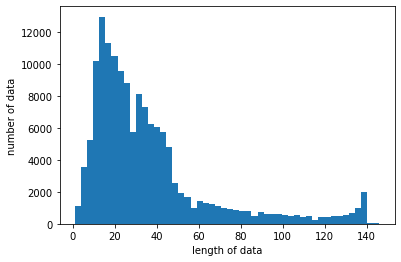

In [15]:
from matplotlib import pyplot as plt

#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in train_data['document']))
print('학습 문장의 평균 길이 :',sum(map(len, train_data['document']))/len(train_data['document']))

plt.hist([len(s) for s in train_data['document']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [16]:
# Store the model we want to use
from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [17]:
tokenized_train_sentences = tokenizer(
    list(train_data['document']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [18]:
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=142, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [19]:
len(tokenized_train_sentences[0].tokens)

142

In [20]:
tokenized_test_sentences = tokenizer(
    list(test_data['document']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [21]:
train_label = train_data['label'].values
test_label = test_data['label'].values

In [22]:
print(train_label[0])

0


In [23]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [24]:
train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

In [25]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
# 문장 분류를 위해선 BERT 위에 classification을 위한 head를 부착해야 합니다.
# 해당 부분을 transformers에서는 라이브러리 하나만 호출하면 됩니다! :-)

In [27]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

In [28]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [29]:
trainer.train() # 1 epoch에 대략 30분 정도 소요됩니다 :-)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.549200
1000,0.443600
1500,0.401800
2000,0.385600
2500,0.368900
3000,0.357200
3500,0.347100
4000,0.332800
4500,0.324500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

TrainOutput(global_step=4569, training_loss=0.38896028623457785, metrics={'train_runtime': 4106.0025, 'train_samples_per_second': 1.113, 'total_flos': 2.215131532768459e+16, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': 8192, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -1839575040, 'train_mem_gpu_alloc_delta': 2169396736, 'train_mem_cpu_peaked_delta': 1856397312, 'train_mem_gpu_peaked_delta': 4193177600})

In [30]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

In [32]:
trainer.evaluate(eval_dataset=test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'eval_accuracy': 0.8600402791057224,
 'eval_f1': 0.8635570363319055,
 'eval_loss': 0.3200184106826782,
 'eval_mem_cpu_alloc_delta': 2199552,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 534921216,
 'eval_precision': 0.8467312254501614,
 'eval_recall': 0.8810651127028449,
 'eval_runtime': 413.4362,
 'eval_samples_per_second': 118.899,
 'init_mem_cpu_alloc_delta': 0,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 0,
 'init_mem_gpu_peaked_delta': 0}

In [33]:
# native training using torch

# model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
# model.to(device)
# model.train()

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# optim = AdamW(model.parameters(), lr=5e-5)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

In [34]:
# predict함수
def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to(device)
    
    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result

In [35]:
print(sentences_predict("영화 개재밌어 ㅋㅋㅋㅋㅋ"))
print(sentences_predict("진짜 재미없네요 ㅋㅋ"))
print(sentences_predict("너 때문에 진짜 짜증나"))
print(sentences_predict("정말 재밌고 좋았어요."))

1
0
0
1


In [36]:
from transformers import pipeline

nlp_sentence_classif = pipeline('sentiment-analysis',model=model, tokenizer=tokenizer, device=0)

print(nlp_sentence_classif('영화 개재밌어 ㅋㅋㅋㅋㅋ'))
print(nlp_sentence_classif('진짜 재미없네요 ㅋㅋ',model= model))
print(nlp_sentence_classif('너 때문에 진짜 짜증나',model= model))
print(nlp_sentence_classif('정말 재밌고 좋았어요.',model= model))

[{'label': 'LABEL_1', 'score': 0.7342406511306763}]
[{'label': 'LABEL_0', 'score': 0.993529736995697}]
[{'label': 'LABEL_0', 'score': 0.9937312602996826}]
[{'label': 'LABEL_1', 'score': 0.9877133965492249}]


끗!